# Scenario
Create a model that will predict whether a airbnb will get a perfect 5.0 rating in San Diego California. The purpose of this model is for airbnb hosts to have a way to evaluate their rentals and make sure that they are meeting all of the criteria to get that perfect review.

## Questions to Answer

1. How many units have a perfect rating?
2. How long have they had perfect rating?
3. How many reviews should the unit have to be considered? (ie, one 5.0 isn't enough)
4. What review metrics have the most impact?
5. What house factors have the most impact?
6. Relationship between price and rating?

## Loading Data

In [100]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, mean_squared_log_error, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import plot_confusion_matrix
from xgboost import XGBClassifier


In [36]:
pd.set_option('display.max_rows', 1000)

## Reviews_df: Details on each review post

In [37]:
reviews_df = pd.read_csv('reviews.csv.gz')

In [38]:
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,29967,62788,2010-07-09,151260,Debbie,When I booked our stay in San Diego at Dennis ...
1,29967,64568,2010-07-14,141552,Eric,This was my first experience with using airbnb...
2,29967,67502,2010-07-22,141591,David,We found the house to be very accommodating--e...
3,29967,70466,2010-07-29,125982,Anders,As advertised and more. Dennis was very helpfu...
4,29967,74876,2010-08-07,29835,Miyoko,We had a great time in San Diego. Denis' house...


## Listing_DF: Baseline DF with many columns

In [39]:
listing_df = pd.read_csv('listings.csv.gz')

In [40]:
listing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            10935 non-null  int64  
 1   listing_url                                   10935 non-null  object 
 2   scrape_id                                     10935 non-null  int64  
 3   last_scraped                                  10935 non-null  object 
 4   name                                          10935 non-null  object 
 5   description                                   10809 non-null  object 
 6   neighborhood_overview                         7440 non-null   object 
 7   picture_url                                   10935 non-null  object 
 8   host_id                                       10935 non-null  int64  
 9   host_url                                      10935 non-null 

In [41]:
listing_df['price']

0         $60.00
1        $282.00
2        $348.00
3        $368.00
4        $264.00
          ...   
10930    $228.00
10931    $168.00
10932    $500.00
10933     $67.00
10934     $88.00
Name: price, Length: 10935, dtype: object

### Fixing Price

In [42]:
listing_df['price'] = listing_df['price'].map(lambda x: x.replace('$',' '))
listing_df['price'] = listing_df['price'].map(lambda x: x.replace(',',''))
listing_df['price'] = listing_df['price'].astype(float)

In [43]:
listing_df['price']

0         60.0
1        282.0
2        348.0
3        368.0
4        264.0
         ...  
10930    228.0
10931    168.0
10932    500.0
10933     67.0
10934     88.0
Name: price, Length: 10935, dtype: float64

## Review Score DF

In [44]:
review_score_df = listing_df[['id', 'price', 'review_scores_rating', 'review_scores_accuracy',
                             'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                             'review_scores_location', 'review_scores_value', 'number_of_reviews',
                             'number_of_reviews_ltm', 'number_of_reviews_l30d']]

In [45]:
df = review_score_df

In [46]:
df.head(1000)

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
0,53157684,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,1,1,0
1,4541431,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,100,16,1
2,41089200,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,12,7,0
3,43078286,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,24,12,0
4,51558974,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,4,0
5,38816619,140.0,5.00,4.00,4.00,5.00,5.00,5.00,4.50,2,0,0
6,29281731,19.0,4.79,4.85,4.85,4.85,4.84,4.87,4.75,67,23,1
7,53205282,25.0,5.00,4.67,5.00,5.00,5.00,5.00,5.00,3,3,1
8,38550805,60.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,1,0,0
9,53479335,39.0,5.00,5.00,5.00,5.00,5.00,5.00,5.00,3,3,1


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10935 entries, 0 to 10934
Data columns (total 12 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           10935 non-null  int64  
 1   price                        10935 non-null  float64
 2   review_scores_rating         9408 non-null   float64
 3   review_scores_accuracy       9385 non-null   float64
 4   review_scores_cleanliness    9385 non-null   float64
 5   review_scores_checkin        9383 non-null   float64
 6   review_scores_communication  9385 non-null   float64
 7   review_scores_location       9383 non-null   float64
 8   review_scores_value          9383 non-null   float64
 9   number_of_reviews            10935 non-null  int64  
 10  number_of_reviews_ltm        10935 non-null  int64  
 11  number_of_reviews_l30d       10935 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 1.0 MB


### Number of Units with a 5.0 Avg Rating

In [48]:
df['review_scores_rating'].value_counts()

5.00    2054
4.80     248
4.91     238
4.86     237
4.88     233
4.89     226
4.83     220
4.92     216
4.67     209
4.96     207
4.94     207
4.90     206
4.50     202
4.93     200
4.75     196
4.95     184
4.85     179
4.97     172
4.87     165
4.00     164
4.82     161
4.84     154
4.98     138
4.81     138
4.79     137
4.78     135
4.76     108
4.73     107
4.71     107
4.70     100
4.74      99
4.77      97
4.60      93
4.72      89
4.69      81
4.63      78
4.68      71
4.65      70
4.64      67
4.99      59
4.33      59
4.57      51
4.58      51
4.62      49
3.00      49
4.59      47
4.66      47
4.56      47
4.61      45
4.40      43
4.53      41
4.44      36
4.52      35
4.54      34
4.55      33
4.43      32
1.00      32
4.25      32
4.38      29
4.47      29
4.46      23
3.67      23
4.51      22
4.42      22
4.48      22
4.45      20
0.00      19
4.20      19
4.32      18
3.50      18
4.39      17
4.29      17
4.41      14
4.35      12
4.17      12
2.00      12
4.14      11

In [49]:
df['review_scores_rating'].isna().sum()

1527

There are 1527 Null records that need to be dealt with. 

In [50]:
nulls = df[df['review_scores_rating'].isna()]

In [51]:
nulls

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
12,565897319227095532,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
23,53189232,217.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
70,42711782,129.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
84,54066812,1524.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
192,674234,307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10899,558819072179126620,329.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
10907,52809856,199.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
10917,586604034293111648,1028.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
10920,579987024038116284,570.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


nulls appear to have no ratings. Let's drop them for now.

In [52]:
df = df.dropna()

In [53]:
df

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
0,53157684,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,1,1,0
1,4541431,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,100,16,1
2,41089200,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,12,7,0
3,43078286,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,24,12,0
4,51558974,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10930,32501571,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,125,36,3
10931,15160579,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,274,90,9
10932,33886026,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,4,0,0
10933,39927378,67.0,4.53,4.82,4.67,4.67,4.69,4.71,4.61,49,10,1


### Creating Classifier Column

In [54]:
df['perfect_score'] = df['review_scores_rating'] == 5.00

In [55]:
df['perfect_score'].value_counts()

False    7332
True     2051
Name: perfect_score, dtype: int64

### Checking # of reviews

In [56]:
df['number_of_reviews'].value_counts()

1      598
2      448
3      352
4      326
5      257
7      226
6      213
9      185
8      168
10     167
11     161
12     145
15     128
14     124
13     123
18     120
19     112
17     108
16     108
20     101
23      98
27      92
24      91
25      90
21      88
29      83
30      78
28      77
26      73
32      67
22      66
33      59
31      58
38      55
51      54
36      52
37      52
42      51
46      51
52      51
54      50
40      50
34      50
48      49
44      48
47      48
41      47
57      47
43      47
39      45
50      44
61      44
35      43
55      42
45      42
64      41
49      40
59      36
53      36
74      36
56      35
60      35
58      34
78      34
69      33
65      32
66      32
73      32
80      31
68      30
83      29
75      28
87      28
76      26
71      26
70      26
81      26
89      25
67      25
62      25
84      25
63      24
86      24
90      24
93      23
117     23
120     23
72      22
156     22
111     22
79      22

In [57]:
df['5+_reviews'] = df['number_of_reviews'] >= 5.00

In [58]:
df

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,perfect_score,5+_reviews
0,53157684,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,1,1,0,True,False
1,4541431,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,100,16,1,False,True
2,41089200,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,12,7,0,False,True
3,43078286,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,24,12,0,False,True
4,51558974,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,4,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10930,32501571,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,125,36,3,False,True
10931,15160579,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,274,90,9,False,True
10932,33886026,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,4,0,0,True,False
10933,39927378,67.0,4.53,4.82,4.67,4.67,4.69,4.71,4.61,49,10,1,False,True


In [59]:
df

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,perfect_score,5+_reviews
0,53157684,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,1,1,0,True,False
1,4541431,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,100,16,1,False,True
2,41089200,348.0,4.92,5.00,4.92,5.00,5.00,4.92,4.92,12,7,0,False,True
3,43078286,368.0,4.88,4.96,4.96,5.00,5.00,4.75,4.71,24,12,0,False,True
4,51558974,264.0,5.00,5.00,4.75,4.75,4.75,5.00,4.75,4,4,0,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10930,32501571,228.0,4.78,4.82,4.85,4.98,4.90,4.82,4.80,125,36,3,False,True
10931,15160579,168.0,4.89,4.94,4.89,4.93,4.94,4.92,4.90,274,90,9,False,True
10932,33886026,500.0,5.00,4.50,5.00,5.00,5.00,5.00,5.00,4,0,0,True,False
10933,39927378,67.0,4.53,4.82,4.67,4.67,4.69,4.71,4.61,49,10,1,False,True


In [62]:
df['stripped_rating'] = df['review_scores_rating'].astype(str).str[:1]

In [63]:
df['stripped_rating']

0        5
1        4
2        4
3        4
4        5
        ..
10930    4
10931    4
10932    5
10933    4
10934    4
Name: stripped_rating, Length: 9383, dtype: object

In [64]:
df = df.sort_values('stripped_rating', ascending=False)

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9383 entries, 0 to 10934
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           9383 non-null   int64  
 1   price                        9383 non-null   float64
 2   review_scores_rating         9383 non-null   float64
 3   review_scores_accuracy       9383 non-null   float64
 4   review_scores_cleanliness    9383 non-null   float64
 5   review_scores_checkin        9383 non-null   float64
 6   review_scores_communication  9383 non-null   float64
 7   review_scores_location       9383 non-null   float64
 8   review_scores_value          9383 non-null   float64
 9   number_of_reviews            9383 non-null   int64  
 10  number_of_reviews_ltm        9383 non-null   int64  
 11  number_of_reviews_l30d       9383 non-null   int64  
 12  perfect_score                9383 non-null   bool   
 13  5+_reviews       

## Attempting visualization

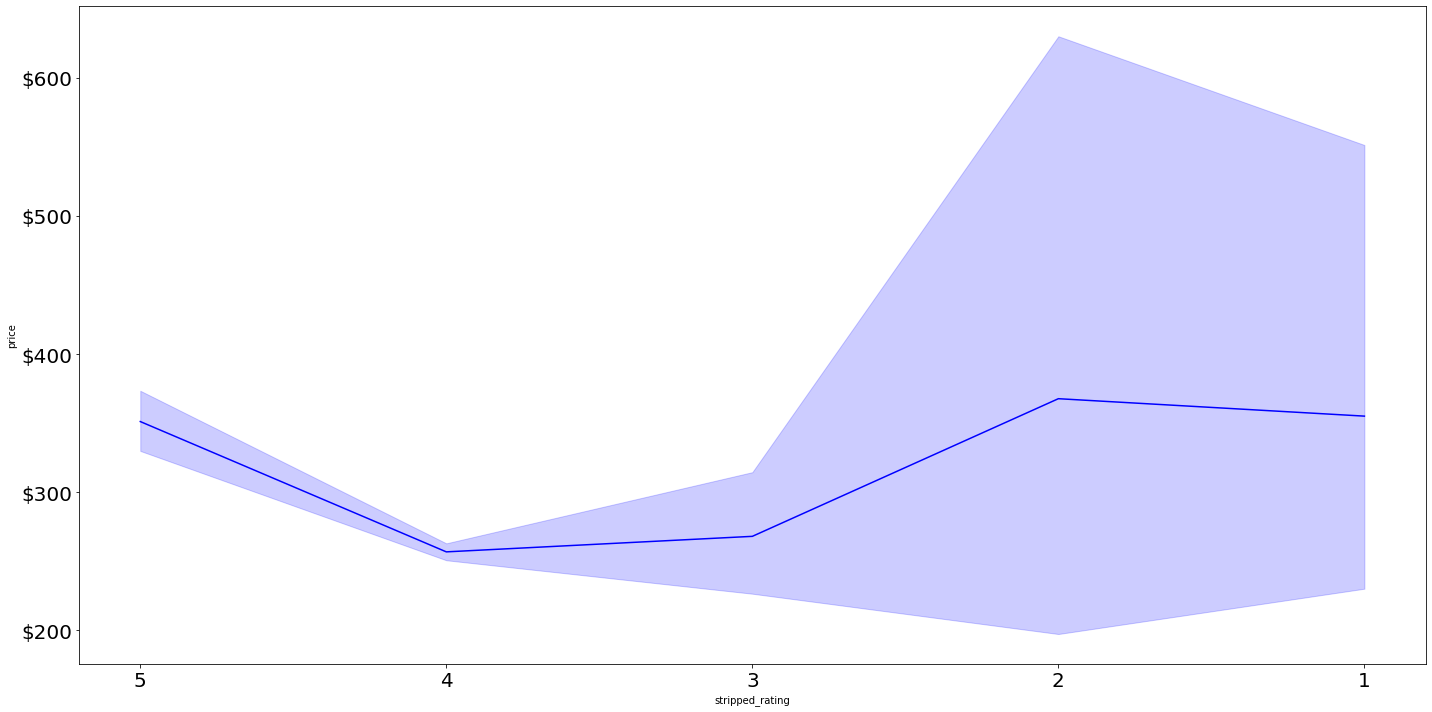

In [65]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

### Analysis: 
This is a very basic plot, but seems to show that there is a "sweet spot" for pricing that is around $300.

In [72]:
new_df = df[df['5+_reviews'] == True]

In [74]:
new_df['5+_reviews'].value_counts()

True    7659
Name: 5+_reviews, dtype: int64

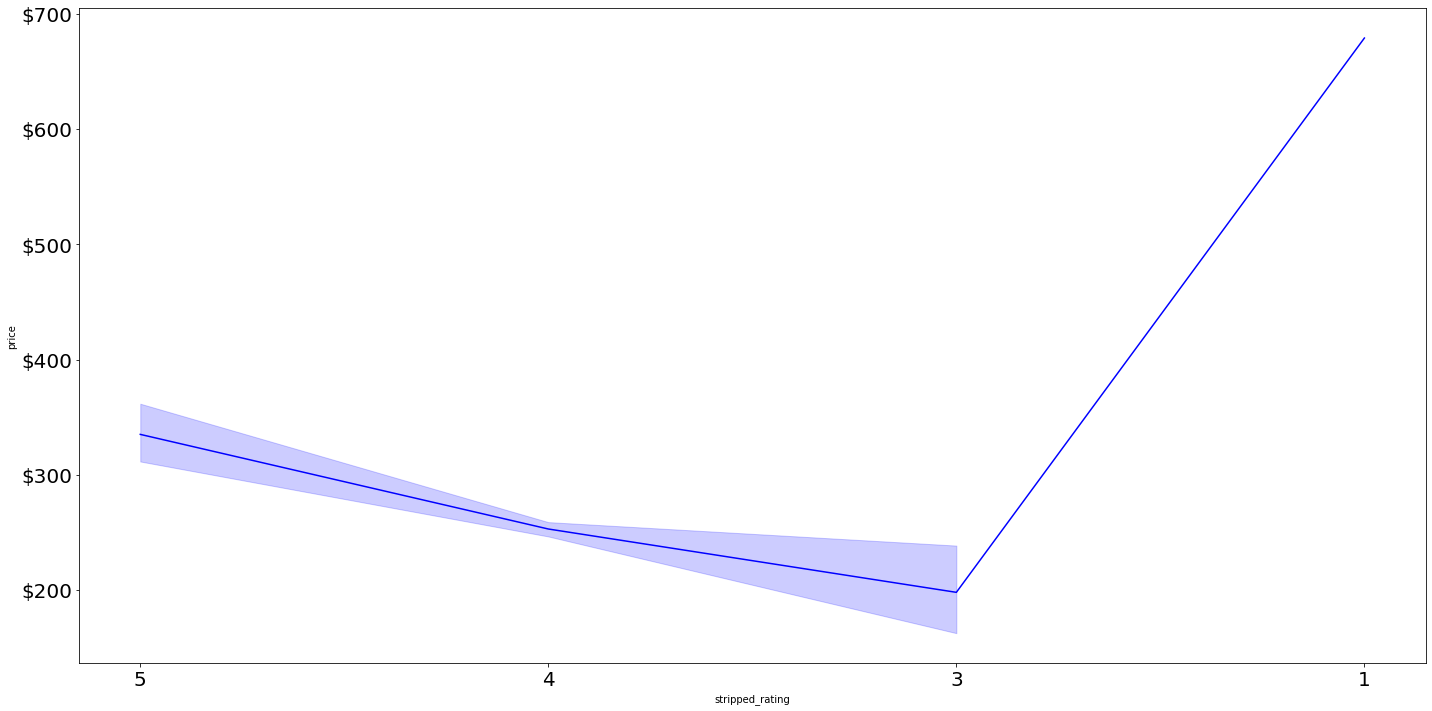

In [75]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=new_df, x='stripped_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [81]:
scatter_df = df[df['review_scores_rating'] >= 4.0]

In [89]:
scatter_mean = scatter_df['price'].mean()
scatter_mean

277.992797904845

In [ ]:
mean = 

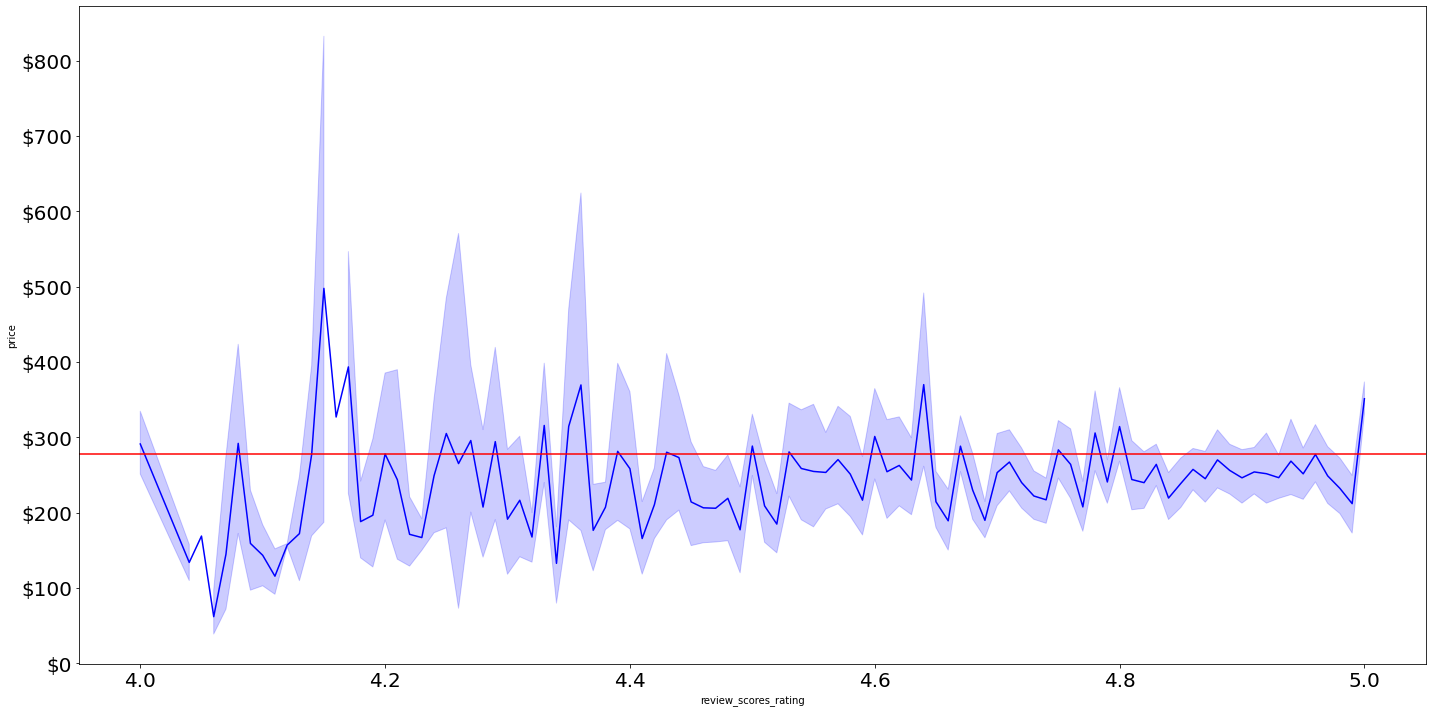

In [90]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=scatter_df, x='review_scores_rating', y='price', color='blue');


#p.set_xlabel("Date", fontsize = 30)
#p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

y1 = p.axhline(scatter_mean, color='red') 
#y2 = p.axvline('2012-01', color='red') #housing market crash ends

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

#p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.savefig('images/us_median_plot_1')

plt.tight_layout()

plt.show();

In [66]:
df.head(1)

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,perfect_score,5+_reviews,stripped_rating
0,53157684,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,1,1,0,True,False,5


In [70]:
df.sort_values('perfect_score', ascending=False).head()

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,perfect_score,5+_reviews,stripped_rating
0,53157684,60.0,5.0,5.00,5.00,5.00,5.00,4.00,5.00,1,1,0,True,False,5
6543,45464825,261.0,5.0,5.00,5.00,5.00,5.00,5.00,5.00,1,1,0,True,False,5
10379,572526513878348724,327.0,5.0,5.00,5.00,5.00,5.00,5.00,5.00,2,2,2,True,False,5
10383,572620505718581430,62.0,5.0,5.00,5.00,5.00,5.00,4.50,5.00,2,2,2,True,False,5
10385,572724481006958064,357.0,5.0,5.00,5.00,5.00,5.00,5.00,5.00,1,1,1,True,False,5
794,5945267,235.0,5.0,4.86,4.86,5.00,5.00,5.00,5.00,8,1,0,True,True,5
10448,575396975848094168,66.0,5.0,4.67,5.00,5.00,5.00,5.00,4.33,3,3,3,True,False,5
9735,53890978,149.0,5.0,5.00,5.00,5.00,5.00,5.00,5.00,6,6,2,True,True,5
9737,53895419,66.0,5.0,5.00,5.00,5.00,5.00,5.00,5.00,4,4,2,True,False,5
9741,53903862,223.0,5.0,5.00,5.00,5.00,5.00,5.00,5.00,1,1,0,True,False,5


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9383 entries, 0 to 2927
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           9383 non-null   int64  
 1   price                        9383 non-null   float64
 2   review_scores_rating         9383 non-null   float64
 3   review_scores_accuracy       9383 non-null   float64
 4   review_scores_cleanliness    9383 non-null   float64
 5   review_scores_checkin        9383 non-null   float64
 6   review_scores_communication  9383 non-null   float64
 7   review_scores_location       9383 non-null   float64
 8   review_scores_value          9383 non-null   float64
 9   number_of_reviews            9383 non-null   int64  
 10  number_of_reviews_ltm        9383 non-null   int64  
 11  number_of_reviews_l30d       9383 non-null   int64  
 12  perfect_score                9383 non-null   bool   
 13  5+_reviews        

## Getting Data Ready for Modelling

In [92]:
cont_features = [col for col in df.columns if df[col].dtype in [np.float64, np.int64]]
feature_df = df.loc[:, cont_features]
feature_df.head()

,id,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d
0,53157684,60.0,5.0,5.00,5.00,5.00,5.0,4.00,5.0,1,1,0
2400,19017284,450.0,5.0,5.00,5.00,5.00,5.0,5.00,5.0,1,0,0
7773,50011357,466.0,5.0,5.00,4.96,5.00,5.0,4.83,5.0,24,24,7
7772,50010335,102.0,5.0,5.00,5.00,5.00,5.0,4.67,5.0,3,3,1
7764,49984610,132.0,5.0,4.75,4.75,4.75,5.0,5.00,5.0,4,4,1


In [95]:
feature_df.drop(columns=('id'), inplace=True)

### One Hot Encoding

In [96]:
need_to_encode = df[['5+_reviews', 'perfect_score']]
ohe = OneHotEncoder()
ohe.fit(need_to_encode)

ohe_1 = ohe.transform(need_to_encode).toarray()

ohe_df = pd.DataFrame(ohe_1, columns=ohe.get_feature_names(need_to_encode.columns))
ohe_df.head(2)

,5+_reviews_False,5+_reviews_True,perfect_score_False,perfect_score_True
0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0


In [98]:
# Combining everything together
cleaned_df = pd.concat([pd.DataFrame(feature_df), ohe_df], axis=1)
cleaned_df.head(2)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,5+_reviews_False,5+_reviews_True,perfect_score_False,perfect_score_True
0,60.0,5.00,5.00,5.00,5.00,5.00,4.00,5.00,1.0,1.0,0.0,1.0,0.0,0.0,1.0
1,282.0,4.87,4.91,4.64,4.99,4.98,4.87,4.86,100.0,16.0,1.0,1.0,0.0,0.0,1.0


#### Dropping One Value for Categoricals

In [99]:
#Dropping a few of the redundant values.
cleaned_df= cleaned_df.drop(['5+_reviews_False', 'perfect_score_False'], axis=1)

In [102]:
cleaned_df.head(1)

,price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,5+_reviews_True,perfect_score_True
0,60.0,5.0,5.0,5.0,5.0,5.0,4.0,5.0,1.0,1.0,0.0,0.0,1.0


## Dealing with Class Imbalance
- Always use class weight parameter in Decision Tree Classifier
- Always stratify Train Test Split.
- Add SMOTE to Training Sets.

In [103]:
cleaned_df['perfect_score_True'].value_counts()

0.0    7332
1.0    2051
Name: perfect_score_True, dtype: int64

In [106]:
cleaned_df.isna().sum()

price                          945
review_scores_rating           945
review_scores_accuracy         945
review_scores_cleanliness      945
review_scores_checkin          945
review_scores_communication    945
review_scores_location         945
review_scores_value            945
number_of_reviews              945
number_of_reviews_ltm          945
number_of_reviews_l30d         945
5+_reviews_True                945
perfect_score_True             945
dtype: int64

In [108]:
cleaned_df = cleaned_df.dropna()

In [109]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8438 entries, 0 to 9382
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   price                        8438 non-null   float64
 1   review_scores_rating         8438 non-null   float64
 2   review_scores_accuracy       8438 non-null   float64
 3   review_scores_cleanliness    8438 non-null   float64
 4   review_scores_checkin        8438 non-null   float64
 5   review_scores_communication  8438 non-null   float64
 6   review_scores_location       8438 non-null   float64
 7   review_scores_value          8438 non-null   float64
 8   number_of_reviews            8438 non-null   float64
 9   number_of_reviews_ltm        8438 non-null   float64
 10  number_of_reviews_l30d       8438 non-null   float64
 11  5+_reviews_True              8438 non-null   float64
 12  perfect_score_True           8438 non-null   float64
dtypes: float64(13)
mem

In [110]:
cleaned_df.isna().sum()

price                          0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
number_of_reviews_ltm          0
number_of_reviews_l30d         0
5+_reviews_True                0
perfect_score_True             0
dtype: int64

In [111]:
balanced_df = cleaned_df.copy()

X = balanced_df.drop(['perfect_score_True'], axis=1)
y = balanced_df['perfect_score_True']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=23)

smote = SMOTE(random_state=23)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 

In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(labels , predictions)*100)

### Metrics Function

In [134]:
def get_metrics(clf, y_pred):
    
    
    clf_acc = accuracy_score(y_test, y_pred) * 100
    print('Accuracy is :{0}'.format(clf_acc))
    clf_prec = precision_score(y_test, y_pred) * 100
    print('Precision is :{0}'.format(clf_prec))
    clf_rcl = recall_score(y_test, y_pred) * 100
    print('Recall is :{0}'.format(clf_rcl))
    clf_f1 = f1_score(y_test, y_pred) * 100
    print('F1 Score is :{0}'.format(clf_f1))
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    clf_roc_auc = auc(false_positive_rate, true_positive_rate)
    print('ROC AUC is :{0}'.format(round(clf_roc_auc, 2)))

## Baseline Decision Tree

In [140]:
dt1 = DecisionTreeClassifier(random_state=23, class_weight="balanced")
dt1.fit(X_train_resampled, y_train_resampled)
dt1_y_pred = dt1.predict(X_test)

In [135]:
get_metrics(dt1, dt1_y_pred)

Accuracy is :81.23222748815165
Precision is :58.57664233576643
Recall is :65.51020408163265
F1 Score is :61.84971098265897
ROC AUC is :0.76


In [115]:
dt1_cv_score = np.mean(cross_val_score(dt1, X_train_resampled, y_train_resampled, cv=3))
dt1_cv_score

0.844318853174467

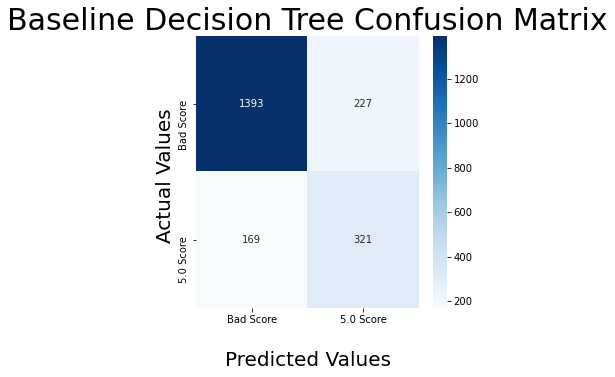

In [118]:
dt1_matrix = confusion_matrix(y_test, dt1_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

### Refining Decision Tree through GridSearchCV

In [119]:
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 3, 4, 5, 6],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6]
}

In [145]:
# Instantiate GridSearchCV
dt2 = DecisionTreeClassifier(random_state=23)

dt_grid_search = GridSearchCV(dt2, dt_param_grid, cv=3, scoring = 'precision')

# Fit to the data
dt_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(random_state=23),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             scoring='precision')

In [146]:
dt_grid_search.best_params_

{'criterion': 'entropy',
 'max_depth': 6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

## Decision Tree 2

In [147]:
dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_split=2,
                             min_samples_leaf=1, class_weight='balanced', random_state=23)
dt2.fit(X_train_resampled, y_train_resampled)
dt2_y_pred = dt2.predict(X_test)

In [148]:
get_metrics(dt2, dt2_y_pred)

Accuracy is :85.35545023696682
Precision is :68.06387225548902
Recall is :69.59183673469389
F1 Score is :68.81937436932391
ROC AUC is :0.8


In [128]:
dt2_cv_score = np.mean(cross_val_score(dt2, X_train_resampled, y_train_resampled, cv=3))
dt2_cv_score

0.8478174308231595

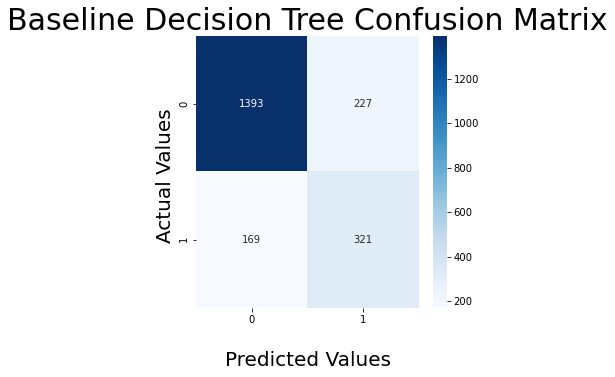

In [149]:
dt2_matrix = confusion_matrix(y_test, dt2_y_pred)

fig, ax = plt.subplots(figsize=(5,5))

ax = sns.heatmap(dt1_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Baseline Decision Tree Confusion Matrix', fontsize = 30);
ax.set_xlabel('\nPredicted Values',fontsize = 20)
ax.set_ylabel('Actual Values ', fontsize=20);

## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['Bad Score','5.0 Score'])
#ax.yaxis.set_ticklabels(['Bad Score','5.0 Score'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Random Forests

In [150]:
rf1_clf = RandomForestClassifier(random_state=23, class_weight="balanced")
rf1_clf.fit(X_train_resampled, y_train_resampled)
rf1_y_pred = rf1_clf.predict(X_test)

In [151]:
get_metrics(rf1_clf, rf1_y_pred)

Accuracy is :85.45023696682465
Precision is :69.6774193548387
Recall is :66.12244897959184
F1 Score is :67.85340314136127
ROC AUC is :0.79


In [152]:
rf1_cv_score = np.mean(cross_val_score(rf1_clf, X_train_resampled, y_train_resampled, cv=3))
rf1_cv_score

0.887949749516248

### GridSearch CV

In [153]:
rf_param_grid = {
    'n_estimators': [10, 30, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [154]:
rf2_clf = RandomForestClassifier(random_state=23)


rf1_grid_search= GridSearchCV(rf2_clf, rf_param_grid, scoring = 'precision', cv=3)
rf1_grid_search.fit(X_train_resampled, y_train_resampled)

print("")
print(f"Random Forest  Optimal Parameters: {rf1_grid_search.best_params_}")


Random Forest  Optimal Parameters: {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}


## Random Forests 2

In [155]:
rf2_clf = RandomForestClassifier(criterion= 'entropy', max_depth= 6, min_samples_leaf= 3,
                                min_samples_split= 5, n_estimators= 100, random_state=23,
                                class_weight='balanced')
rf2_clf.fit(X_train_resampled, y_train_resampled)
rf2_y_pred = rf2_clf.predict(X_test)

In [156]:
get_metrics(rf2_clf, rf2_y_pred)

Accuracy is :85.59241706161137
Precision is :72.24880382775119
Recall is :61.63265306122449
F1 Score is :66.51982378854625
ROC AUC is :0.77


In [157]:
rf2_cv_score = np.mean(cross_val_score(rf2_clf, X_train_resampled, y_train_resampled, cv=3))
rf2_cv_score

0.8461703556322951

## XGBoost Model

In [158]:
# Instantiate XGBClassifier
clf = XGBClassifier(random_state=23)

# Fit XGBClassifier
xg1 = clf.fit(X_train_resampled, y_train_resampled)

# Predict on training and test sets
training_preds = clf.predict(X_train_resampled)
xg1_y_pred = clf.predict(X_test)

In [159]:
get_metrics(xg1, xg1_y_pred)

Accuracy is :85.97156398104265
Precision is :71.08695652173913
Recall is :66.73469387755102
F1 Score is :68.84210526315789
ROC AUC is :0.79


In [160]:
xg1_cv_score = np.mean(cross_val_score(xg1, X_train_resampled, y_train_resampled, cv=3))
xg1_cv_score

0.8618188881138694

### GridSearch

In [161]:
boost_param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6],
    'min_child_weight': [1, 2],
    'subsample': [0.5, 0.7],
    'n_estimators': [100],
}

In [162]:
xg2 = XGBClassifier(random_state=23)

grid_clf = GridSearchCV(xg2, boost_param_grid, scoring='recall', cv=3, n_jobs=1)
grid_clf.fit(X_train_resampled, y_train_resampled)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 2
n_estimators: 100
subsample: 0.5


In [163]:
xg2 = XGBClassifier(learning_rate= 0.1, max_depth=6, min_child_weight=2,
                                n_estimators=100, subsample=0.5, random_state=23)
xg2.fit(X_train_resampled, y_train_resampled)
xg2_y_pred = xg2.predict(X_test)

In [164]:
get_metrics(xg2, xg2_y_pred)

Accuracy is :85.54502369668246
Precision is :69.63906581740976
Recall is :66.93877551020408
F1 Score is :68.26222684703434
ROC AUC is :0.79


In [166]:
xg2_cv_score = np.mean(cross_val_score(xg2, X_train_resampled, y_train_resampled, cv=3))
xg2_cv_score

0.8737510116545141